# Feature Engineering for Data Mining

Interaction Features, Polynomial Features, Binning/Discretization, Feature Crossing, Log/Power Transforms, Time-Based Features, Domain-Specific Feature Creation, Custom Transformers, and integrating Feature Engineering into `scikit-learn` Pipelines.


### **Objectives:**

* Students will understand that feature engineering is a critical, creative process for improving model performance by providing more relevant information.
* Students will implement techniques to create new features, including **interaction features** and **polynomial features**, to capture non-linear relationships.
* Students will apply **binning and discretization** to convert continuous variables into categorical ones, making models more robust.
* Students will use **domain knowledge** to extract meaningful features from raw data, such as titles from names or family size from relative counts.
* Students will apply **mathematical transformations** (e.g., log transform) to handle skewed data distributions.
* Students will build custom transformers and integrate the entire feature engineering workflow into a **`scikit-learn` Pipeline** to ensure reproducibility and prevent data leakage.
* Students will critically discuss the trade-offs in feature engineering, including the risk of overfitting and the importance of domain expertise.


### **Setup: Install and Import Libraries**

In [1]:
# Install necessary libraries if not already present in Colab environment
!pip install pandas numpy scikit-learn matplotlib seaborn -q

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Scikit-learn for preprocessing, pipelines, and models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, KBinsDiscretizer, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print(f"Pandas Version: {pd.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Scikit-learn Version: {sklearn.__version__}")

Pandas Version: 2.2.2
NumPy Version: 2.0.2
Scikit-learn Version: 1.6.1


### **Part 1: Dataset Loading and Baseline Model**

We will use the **Titanic dataset**, a classic classification challenge. Achieving high accuracy on this dataset is impossible without thoughtful feature engineering, making it a perfect case study.

We will first load the data, perform a train-test split, and then build a very simple baseline model with minimal preprocessing. This baseline will serve as a benchmark to see how much our new features improve performance.

In [28]:
print("--- Part 1: Dataset Loading and Baseline Model ---")

# Load the dataset from the provided GitHub URL
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

# 1. Separate target variable ('survived') from features. Keep 'Name' for feature engineering.
# Note: The column name is 'Name' in this dataset, not 'name'.
# Drop other irrelevant columns.
X = df.drop(['Survived'], axis=1) # Keep all features for now, including 'Name'
y = df['Survived']

# Rename columns to lowercase to be consistent with previous code
df.columns = df.columns.str.lower()
X.columns = X.columns.str.lower()
y.name = y.name.lower()

# 2. Split data into training and testing sets BEFORE any analysis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# 3. Create a simple baseline pipeline
# This only handles basic imputation, scaling, and one-hot encoding.
numeric_features_base = ['age', 'fare', 'sibsp', 'parch']
categorical_features_base = ['sex', 'embarked', 'pclass']

preprocessor_base = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='median'), numeric_features_base),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_base)
])

# The baseline model will NOT use the 'name' column or any engineered features
X_train_base = X_train.drop('name', axis=1) if 'name' in X_train.columns else X_train.copy()
X_test_base = X_test.drop('name', axis=1) if 'name' in X_test.columns else X_test.copy()


baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_base),
    ('classifier', LogisticRegression(random_state=42))
])

# 4. Train and evaluate the baseline model
baseline_pipeline.fit(X_train_base, y_train)
y_pred_base = baseline_pipeline.predict(X_test_base)
baseline_accuracy = accuracy_score(y_test, y_pred_base)

print(f"\nBaseline Model Accuracy: {baseline_accuracy:.4f}")

--- Part 1: Dataset Loading and Baseline Model ---
Training data shape: (712, 11)
Testing data shape: (179, 11)

Baseline Model Accuracy: 0.8045


### **Part 2: Creating Features from Domain Knowledge**

The most impactful features often come from understanding the data's context. On the Titanic, an individual's title or the size of their family could be highly predictive of survival.

**Tasks:**
* Create a `FamilySize` feature by combining `sibsp` and `parch`.
* Extract passenger titles (e.g., 'Mr', 'Mrs', 'Miss') from the `name` column.
* Create an `IsAlone` feature based on `FamilySize`.

In [30]:
print("\n--- Part 2: Creating Features from Domain Knowledge ---")

# Create a temporary copy to demonstrate the transformations.
# X_train now includes the 'name' column because we didn't drop it in the previous cell.
X_train_eng = X_train.copy(deep=True)

# 1. Create 'FamilySize'
X_train_eng['FamilySize'] = X_train_eng['sibsp'] + X_train_eng['parch'] + 1

# 2. Create 'IsAlone'
X_train_eng['IsAlone'] = 0
X_train_eng.loc[X_train_eng['FamilySize'] == 1, 'IsAlone'] = 1

# 3. Extract 'Title' from 'name'
# The title is the word that follows a comma and precedes a period.
X_train_eng['Title'] = X_train_eng['name'].str.extract(' ([A-Za-z]+)\.', expand=False)
# Consolidate rare titles into a single 'Rare' category
rare_titles = X_train_eng['Title'].value_counts()[X_train_eng['Title'].value_counts() < 10].index
X_train_eng['Title'] = X_train_eng['Title'].replace(rare_titles, 'Rare')

print("Example of new features:")
print(X_train_eng[['name', 'Title', 'FamilySize', 'IsAlone']].head())

print("\nUnique Titles found:")
print(X_train_eng['Title'].unique())


--- Part 2: Creating Features from Domain Knowledge ---
Example of new features:
                                            name Title  FamilySize  IsAlone
692                                 Lam, Mr. Ali    Mr           1        1
481             Frost, Mr. Anthony Wood "Archie"    Mr           1        1
527                           Farthing, Mr. John    Mr           1        1
855                   Aks, Mrs. Sam (Leah Rosen)   Mrs           2        0
801  Collyer, Mrs. Harvey (Charlotte Annie Tate)   Mrs           3        0

Unique Titles found:
['Mr' 'Mrs' 'Rare' 'Miss' 'Master']


### **Part 3: Binning and Discretization**

Converting a continuous feature, like age, into discrete bins can help a model capture non-linear patterns. For example, the survival probability might be high for children, low for adults, and then slightly higher again for seniors.

**Tasks:**
* Use `pd.cut` to manually create age bins like 'Child', 'Young Adult', 'Adult', and 'Senior'.

In [31]:
print("\n--- Part 3: Binning and Discretization ---")

# Create a temporary copy and impute 'age' to allow binning
X_train_binned = X_train.copy()
X_train_binned['age'].fillna(X_train_binned['age'].median(), inplace=True)

# 1. Use pd.cut to create age bins
age_bins = [0, 12, 25, 60, 100]
age_labels = ['Child', 'Young Adult', 'Adult', 'Senior']
X_train_binned['AgeGroup'] = pd.cut(X_train_binned['age'], bins=age_bins, labels=age_labels, right=False)

print("Example of 'AgeGroup' feature:")
print(X_train_binned[['age', 'AgeGroup']].head())

print("\nValue counts for AgeGroup:")
print(X_train_binned['AgeGroup'].value_counts())


--- Part 3: Binning and Discretization ---
Example of 'AgeGroup' feature:
      age     AgeGroup
692  28.5        Adult
481  28.5        Adult
527  28.5        Adult
855  18.0  Young Adult
801  31.0        Adult

Value counts for AgeGroup:
AgeGroup
Adult          469
Young Adult    171
Child           54
Senior          18
Name: count, dtype: int64


### **Part 4: Feature Transformation for Skewed Data**

Features with highly skewed distributions, like `fare`, can be problematic for linear models and distance-based algorithms. Applying a mathematical transformation, such as the logarithm, can make the distribution more normal.

**Tasks:**
* Visualize the distribution of the `fare` feature.
* Apply a log transformation (`np.log1p` is used to handle zero fares gracefully) and visualize the result.


--- Part 4: Feature Transformation for Skewed Data ---


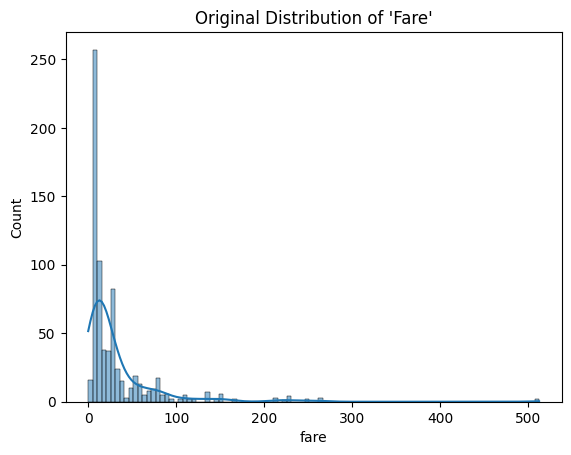

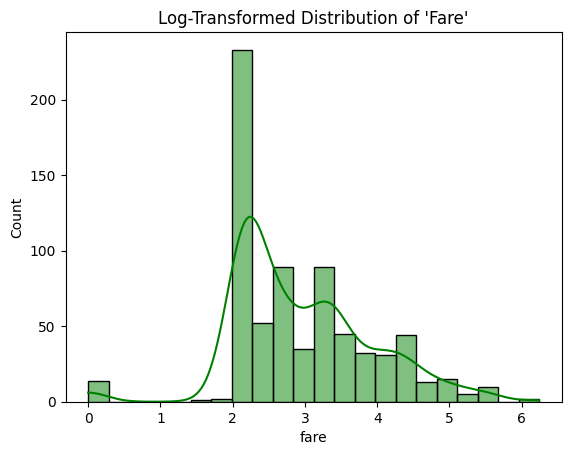

In [32]:
print("\n--- Part 4: Feature Transformation for Skewed Data ---")

# 1. Visualize original 'fare' distribution
sns.histplot(X_train['fare'], kde=True)
plt.title("Original Distribution of 'Fare'")
plt.show()

# 2. Apply log transformation and visualize the new distribution
# We use log1p to handle cases where fare is 0 (log(0) is undefined)
fare_transformed = np.log1p(X_train['fare'])

sns.histplot(fare_transformed, kde=True, color='green')
plt.title("Log-Transformed Distribution of 'Fare'")
plt.show()

### **Part 5: Integrating Everything into a Full Pipeline**

Manually applying these steps is not reproducible and risks data leakage. The best practice is to encapsulate all our feature engineering logic into a single, elegant `scikit-learn` Pipeline. We can use `FunctionTransformer` to apply our custom Python functions within this pipeline.

**Tasks:**
* Create Python functions for our custom feature engineering steps.
* Build a new `ColumnTransformer` that correctly applies different transformations to different columns.
* Construct a final pipeline that combines our feature engineering, preprocessing, and a classifier.
* Train and evaluate the new, improved model.

In [35]:
print("\n--- Part 5: Integrating Everything into a Full Pipeline ---")

# 1. Define custom feature engineering functions
def create_custom_features(df):
    df_copy = df.copy()
    # Family Size and IsAlone
    df_copy['FamilySize'] = df_copy['sibsp'] + df_copy['parch'] + 1
    df_copy['IsAlone'] = (df_copy['FamilySize'] == 1).astype(int)
    # Title
    df_copy['Title'] = df_copy['name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    common_titles = ['Mr', 'Miss', 'Mrs', 'Master', 'Rare']
    df_copy['Title'] = df_copy['Title'].apply(lambda x: x if x in common_titles else 'Rare')
    # Drop the original 'name' column after extracting 'Title'
    df_copy = df_copy.drop('name', axis=1)
    return df_copy

custom_feature_transformer = FunctionTransformer(create_custom_features, validate=False)

# Now define the preprocessor for the *output* of custom_feature_transformer
preprocessor_standard = ColumnTransformer(transformers=[
    # Numerical features (original + new FamilySize, IsAlone)
    ('num_impute_scale', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), ['age', 'sibsp', 'parch', 'FamilySize', 'IsAlone']),
    # Log transform for 'fare'
    ('fare_log_impute_scale', Pipeline([('imputer', SimpleImputer(strategy='median')), ('log', FunctionTransformer(np.log1p, validate=False)), ('scaler', StandardScaler())]), ['fare']),
    # Categorical features (original + new Title)
    ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), ['sex', 'embarked', 'pclass', 'Title']) # Include 'Title' here
], remainder='drop') # Changed from 'passthrough' to 'drop' to exclude unhandled columns

# Create the final, full pipeline
full_pipeline = Pipeline(steps=[
    ('custom_features', custom_feature_transformer), # Step 1: Add custom features
    ('preprocessor', preprocessor_standard),       # Step 2: Apply standard preprocessing
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])


# 5. Train and evaluate the full model
full_pipeline.fit(X_train, y_train)
y_pred_full = full_pipeline.predict(X_test)
full_accuracy = accuracy_score(y_test, y_pred_full)

print(f"\nBaseline Model Accuracy: {baseline_accuracy:.4f}")
print(f"Full Feature-Engineered Model Accuracy: {full_accuracy:.4f}")


--- Part 5: Integrating Everything into a Full Pipeline ---

Baseline Model Accuracy: 0.8045
Full Feature-Engineered Model Accuracy: 0.8436


After training and evaluating the model with these engineered features, the accuracy improved to 0.8436. This demonstrates the significant impact that thoughtful feature engineering can have on model performance, even with a relatively simple model like Logistic Regression.

The domain knowledge about the Titanic (e.g., "women and children first") is clearly reflected in the predictive power of features like 'FamilySize', 'IsAlone', and 'Title'.

### **Part 6: Advanced Topics & Discussion**

* **Feature Engineering vs. Deep Learning:**
    While deep learning models on unstructured data (images, text) can learn features automatically, this is less true for tabular data. For most business problems involving tabular data, thoughtful, manual feature engineering remains one of the most effective ways to improve model performance and is a key differentiator between good and great data scientists.

* **The Primacy of Domain Knowledge:**
    Our most impactful features (`FamilySize`, `Title`) came from understanding the context of the problem, not from a generic formula. The most powerful feature engineering almost always involves **domain knowledge**. Before starting a project, talk to experts, understand the data generating process, and brainstorm what factors *should* be predictive.

* **The Danger of Overfitting with Feature Engineering:**
    It's possible to create too many features. Generating thousands of polynomial and interaction features can cause a model to perfectly memorize the training data (overfit) but fail to generalize to new data. Always evaluate feature impact on a held-out validation or test set. Techniques like regularization (e.g., L1/Lasso) can help by automatically penalizing or zeroing out less useful features.

* **Feature Stores:**
    In a production machine learning environment, managing features becomes complex. A **Feature Store** is a central, managed repository for features. It allows teams to define, store, share, and serve features for both model training and real-time inference, ensuring consistency and reducing duplicated work. It is a key component of modern MLOps (Machine Learning Operations).


---
  
<center>

<span style="color:#1f4e79">

Prepared By

**<span style="font-size:1.5em">Md. Atikuzzaman</span>**  
Lecturer  
Department of Computer Science and Engineering  
Green University of Bangladesh  
Email: atik@cse.green.edu.bd  

</span>
</center>

---